Code for **"Inpainting"** figures $6$, $8$ and 7 (top) from the main paper.

In [12]:
"""
*Uncomment if running on colab*
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
"""
!git clone https://github.com/DmitryUlyanov/deep-image-prior
!mv deep-image-prior/* ./

fatal: destination path 'deep-image-prior' already exists and is not an empty directory.
mv: cannot stat 'deep-image-prior/*': No such file or directory


# Import libs

In [13]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim

from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

# Choose figure

In [14]:
## Fig 6
# img_path  = 'data/inpainting/vase.png'
# mask_path = 'data/inpainting/vase_mask.png'

## Fig 8
# img_path  = 'data/inpainting/library.png'
# mask_path = 'data/inpainting/library_mask.png'

## Fig 7 (top)
img_path  = 'data/inpainting/kate.png'
mask_path = 'data/inpainting/kate_mask.png'

# Another text inpainting example
# img_path  = 'data/inpainting/peppers.png'
# mask_path = 'data/inpainting/peppers_mask.png'

NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet

# Load mask

In [15]:
img_pil, img_np = get_image(img_path, imsize)
img_mask_pil, img_mask_np = get_image(mask_path, imsize)

### Center crop

In [16]:
img_mask_pil = crop_image(img_mask_pil, dim_div_by)
img_pil      = crop_image(img_pil,      dim_div_by)

img_np      = pil_to_np(img_pil)
img_mask_np = pil_to_np(img_mask_pil)

In [17]:
help(crop_image)

Help on function crop_image in module utils.common_utils:

crop_image(img, d=32)
    Make dimensions divisible by `d`



### Visualize

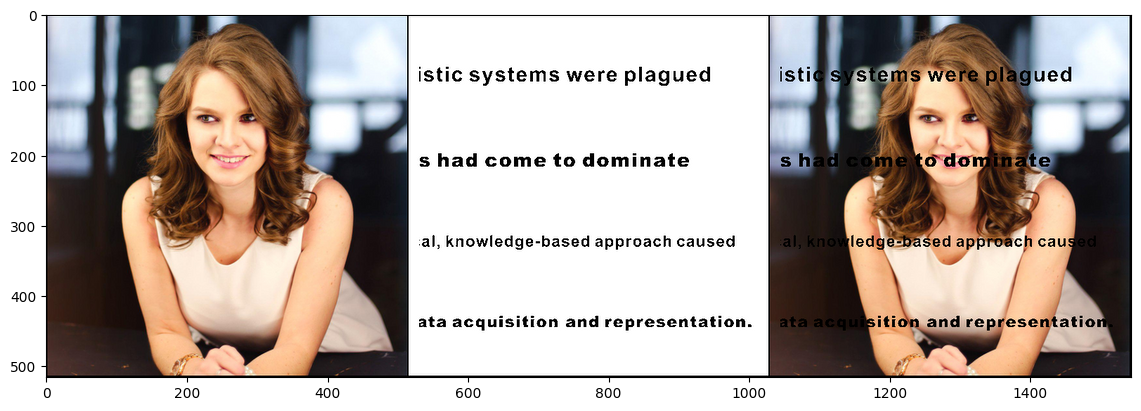

In [18]:
img_mask_var = np_to_torch(img_mask_np).type(dtype)

plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);

# Setup

In [19]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

In [20]:
if 'vase.png' in img_path:
    INPUT = 'meshgrid'
    input_depth = 2
    LR = 0.01
    num_iter = 5001
    param_noise = False
    show_every = 50
    figsize = 5
    reg_noise_std = 0.03

    net = skip(input_depth, img_np.shape[0],
               num_channels_down = [128] * 5,
               num_channels_up   = [128] * 5,
               num_channels_skip = [0] * 5,
               upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

elif ('kate.png' in img_path) or ('peppers.png' in img_path):
    # Same params and net as in super-resolution and denoising
    INPUT = 'noise'
    input_depth = 32
    LR = 0.01
    num_iter = 6001
    param_noise = False
    show_every = 50
    figsize = 5
    reg_noise_std = 0.03

    net = skip(input_depth, img_np.shape[0],
               num_channels_down = [128] * 5,
               num_channels_up =   [128] * 5,
               num_channels_skip =    [128] * 5,
               filter_size_up = 3, filter_size_down = 3,
               upsample_mode='nearest', filter_skip_size=1,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

elif 'library.png' in img_path:

    INPUT = 'noise'
    input_depth = 1

    num_iter = 3001
    show_every = 50
    figsize = 8
    reg_noise_std = 0.00
    param_noise = True

    if 'skip' in NET_TYPE:

        depth = int(NET_TYPE[-1])
        net = skip(input_depth, img_np.shape[0],
               num_channels_down = [16, 32, 64, 128, 128, 128][:depth],
               num_channels_up =   [16, 32, 64, 128, 128, 128][:depth],
               num_channels_skip =    [0, 0, 0, 0, 0, 0][:depth],
               filter_size_up = 3,filter_size_down = 5,  filter_skip_size=1,
               upsample_mode='nearest', # downsample_mode='avg',
               need1x1_up=False,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

        LR = 0.01

    elif NET_TYPE == 'UNET':

        net = UNet(num_input_channels=input_depth, num_output_channels=3,
                   feature_scale=8, more_layers=1,
                   concat_x=False, upsample_mode='deconv',
                   pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)

        LR = 0.001
        param_noise = False

    elif NET_TYPE == 'ResNet':

        net = ResNet(input_depth, img_np.shape[0], 8, 32, need_sigmoid=True, act_fun='LeakyReLU')

        LR = 0.001
        param_noise = False

    else:
        assert False
else:
    assert False

net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

In [21]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

Number of params: 3002627


# Main loop

In [23]:
i = 0
out_nps, losses = [],[]
def closure():

    global i
    global out_nps

    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50

    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)


    out = net(net_input)

    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()

    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        out_nps.append(np.clip(out_np, 0, 1))

    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

Output hidden; open in https://colab.research.google.com to view.

In [24]:
import cv2
import numpy as np
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from skimage.metrics import structural_similarity as ssim

def calculate_psnr_and_mse(imageA, imageB):
    mse = mean_squared_error(imageA, imageB)
    psnr = peak_signal_noise_ratio(imageA, imageB)
    return mse, psnr


def calculate_ssim(imageA, imageB):
    return ssim(imageA, imageB, data_range=imageB.max() - imageB.min())


# Load the images
original = img_np
# recovered = img_np
# recovered = img_mask_np*img_np
# recovered = out_nps[0]
# recovered = out_nps[50]
recovered = out_nps[100]

original = np.transpose(original, (1, 2, 0))
recovered = np.transpose(recovered, (1, 2, 0))

# Convert images to grayscale if they are not
if len(original.shape) == 3:
    original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
if len(recovered.shape) == 3:
    recovered = cv2.cvtColor(recovered, cv2.COLOR_BGR2GRAY)

mse, psnr = calculate_psnr_and_mse(original, recovered)
print(f"MSE: {mse}, PSNR: {psnr}")
ssim_value = calculate_ssim(original, recovered)
print(f"SSIM: {ssim_value}")

MSE: 0.00012038329176231974, PSNR: 39.194337854948174
SSIM: 0.9763369103547205


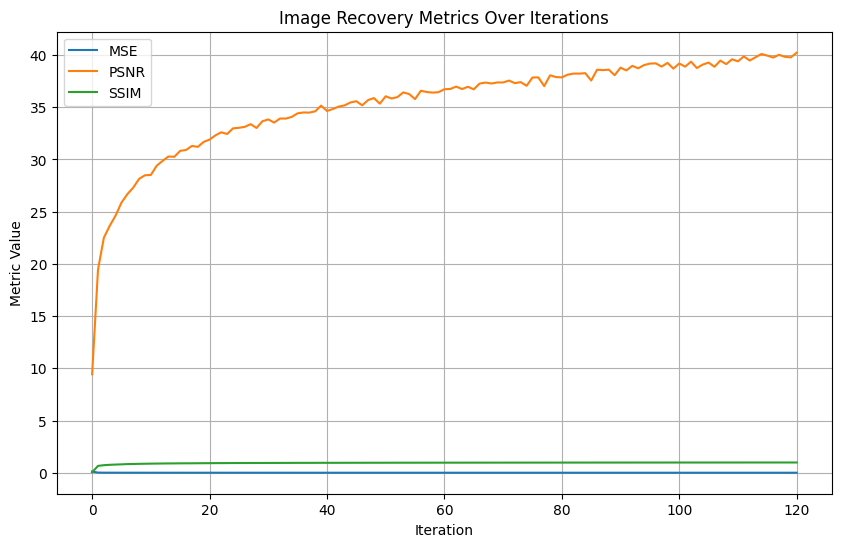

In [25]:
mses = []
psnrs = []
ssims = []

for recovered in out_nps:
    # Compute MSE
    original = np.transpose(img_np, (1, 2, 0))
    recovered = np.transpose(recovered, (1, 2, 0))

    # Convert images to grayscale if they are not
    if len(original.shape) == 3:
        original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    if len(recovered.shape) == 3:
        recovered = cv2.cvtColor(recovered, cv2.COLOR_BGR2GRAY)

    mse_value, psnr_value = calculate_psnr_and_mse(original, recovered)
    mses.append(mse_value)

    psnrs.append(psnr_value)

    # Compute SSIM
    ssim_value = calculate_ssim(original, recovered)
    ssims.append(ssim_value)

# Plotting the metrics
iterations = range(len(out_nps))
plt.figure(figsize=(10, 6))
plt.plot(iterations, mses, label='MSE')
plt.plot(iterations, psnrs, label='PSNR')
plt.plot(iterations, ssims, label='SSIM')
plt.xlabel('Iteration')
plt.ylabel('Metric Value')
plt.title('Image Recovery Metrics Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

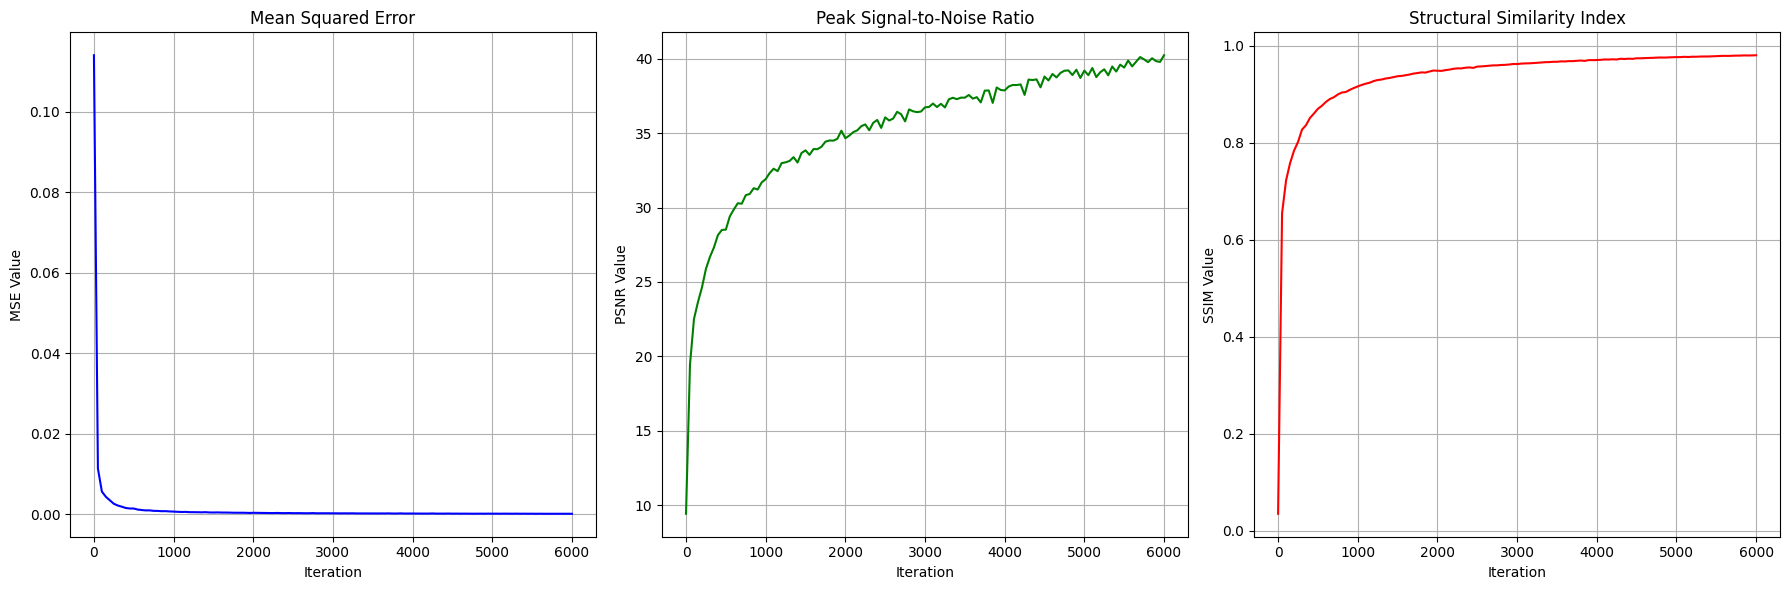

In [26]:
iterations1 = [50*i for i in iterations]

# Plotting the metrics in three separate plots, displayed horizontally
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# MSE plot
axs[0].plot(iterations1, mses, label='MSE', color='blue')
axs[0].set_title('Mean Squared Error')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('MSE Value')
axs[0].grid(True)

# PSNR plot
axs[1].plot(iterations1, psnrs, label='PSNR', color='green')
axs[1].set_title('Peak Signal-to-Noise Ratio')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('PSNR Value')
axs[1].grid(True)

# SSIM plot
axs[2].plot(iterations1, ssims, label='SSIM', color='red')
axs[2].set_title('Structural Similarity Index')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('SSIM Value')
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
out_np = torch_to_np(net(net_input))
plot_image_grid([out_np], factor=5);